<a href="https://colab.research.google.com/github/Eshaa2001/BrainAge/blob/main/Brain_Aging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install nibabel

In [ ]:
!pip install ace_tools
!pip install ace-tools # Install the missing library using pip. Note the hyphen instead of underscore.

In [ ]:
import os
import shutil
import random
import nibabel as nib
import numpy as np
from pathlib import Path

In [ ]:
# Mount your paths
drive_base = Path("/content/drive/MyDrive/Hippocampus/Hippocampus")
output_base = Path("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus")

In [ ]:
# nnU-Net folders
imagesTr_dir = output_base / "imagesTr"
imagesTs_dir = output_base / "imagesTs"
labelsTr_dir = output_base / "labelsTr"

In [ ]:
# Create directories
imagesTr_dir.mkdir(parents=True, exist_ok=True)
imagesTs_dir.mkdir(parents=True, exist_ok=True)
labelsTr_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
# Collect all subfolders
subfolders = [f for f in drive_base.iterdir() if f.is_dir()]
random.seed(42)
random.shuffle(subfolders)

In [ ]:
# Train/test split
split_idx = int(0.8 * len(subfolders))
train_folders = subfolders[:split_idx]
test_folders = subfolders[split_idx:]

In [ ]:
def extract_hippocampus(seg_path):
    seg_img = nib.load(str(seg_path))
    data = seg_img.get_fdata()
    affine = seg_img.affine

    # Round and cast to ensure integers only
    data = np.round(data).astype(int)
    print(data == 53)
    # Clean label map: 0=background, 1=left hippo (17), 2=right hippo (53)
    data_mapped = np.zeros_like(data, dtype=int)
    data_mapped[data == 17] = 1
    data_mapped[data == 53] = 2

    # Save without passing header (safer)
    return nib.Nifti1Image(data_mapped, affine)


In [ ]:
# Process training data
for folder in train_folders:
    nii_files = list(folder.glob("*.nii.gz"))
    image_file = next(f for f in nii_files if "seg" not in f.name.lower())
    label_file = next(f for f in nii_files if "seg" in f.name.lower())

    case_id = folder.name
    new_image_name = f"{case_id}_0000.nii.gz"
    new_label_name = f"{case_id}.nii.gz"

    # Copy image
    shutil.copy(image_file, imagesTr_dir / new_image_name)

    # --- Filter and remap labels (17 → 1, 53 → 2, else 0) ---
    seg_img = nib.load(label_file)
    seg_data = seg_img.get_fdata()
    seg_data = np.round(seg_data)  # Ensure proper rounding

    mapped = np.zeros_like(seg_data, dtype=np.uint8)
    mapped[seg_data == 17] = 1
    mapped[seg_data == 53] = 2

    new_label = nib.Nifti1Image(mapped, seg_img.affine)
    new_label.set_data_dtype(np.uint8)  # Important!
    nib.save(new_label, labelsTr_dir / new_label_name)


In [ ]:
labels = nib.load("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/labelsTr/HC_021.nii.gz").get_fdata()
print(np.unique(labels))

[0. 1. 2.]


In [ ]:
# Process test data
for folder in test_folders:
    nii_files = list(folder.glob("*.nii.gz"))
    image_file = next(f for f in nii_files if "seg" not in f.name.lower())

    case_id = folder.name
    new_image_name = f"{case_id}_0000.nii.gz"
    shutil.copy(image_file, imagesTs_dir / new_image_name)

print("✅ All done: nnU-Net format ready!")

✅ All done: nnU-Net format ready!


In [ ]:
import json
train_cases = sorted(imagesTr_dir.glob("*.nii.gz"))
test_cases = sorted(imagesTs_dir.glob("*.nii.gz"))

dataset_json = {
    "name": "HippocampusCustom",
    "description": "Hippocampus segmentation using values 17 and 53",
    "tensorImageSize": "3D",
    "reference": "Custom OASIS-based dataset",
    "licence": "Custom",
    "release": "1.0",
    "modality": {"0": "MRI"},
    "labels": {
        "0": "background",
        "1": "left_hippocampus",
        "2": "right_hippocampus"
    },
    "numTraining": len(train_cases),
    "numTest": len(test_cases),
    "training": [
        {
            "image": f"./imagesTr/{img.name}",
            "label": f"./labelsTr/{img.name.replace('_0000', '')}"
        } for img in train_cases
    ],
    "test": [f"./imagesTs/{img.name}" for img in test_cases]
}

with open(output_base / "dataset.json", "w") as f:
    json.dump(dataset_json, f, indent=4)

print("✅ dataset.json written!")


✅ dataset.json written!


In [ ]:
# import os
# import json
# from pathlib import Path

# dataset_path = Path("/content/drive/MyDrive/nnUNet_raw_data/Task103_Hippocampus")
# imagesTr = dataset_path / "imagesTr"
# labelsTr = dataset_path / "labelsTr"
# imagesTs = dataset_path / "imagesTs"

# training = []
# for f in sorted(imagesTr.glob("*.nii.gz")):
#     case_id = f.name.replace("_0000.nii.gz", "")
#     training.append({
#         "image": f"./imagesTr/{case_id}_0000.nii.gz",
#         "label": f"./labelsTr/{case_id}.nii.gz"
#     })

# test = [f"./imagesTs/{f.name}" for f in sorted(imagesTs.glob("*.nii.gz"))]

# dataset_dict = {
#     "name": "Hippocampus",
#     "description": "Left and Right Hippocampus Segmentation",
#     "tensorImageSize": "3D",
#     "reference": "Manual segmentation from [source]",
#     "licence": "CC-BY",
#     "release": "1.0",
#     "modality": {
#         "0": "MRI"
#     },
#     "labels": {
#         "0": "background",
#         "17": "left_hippocampus",
#         "53": "right_hippocampus"
#     },
#     "numTraining": len(training),
#     "numTest": len(test),
#     "training": training,
#     "test": test
# }

# # Save to dataset.json
# with open(dataset_path / "dataset.json", "w") as f:
#     json.dump(dataset_dict, f, indent=4)

# print("✅ dataset.json created successfully!")


✅ dataset.json created successfully!


In [ ]:
# import os
# import json
# from pathlib import Path
# import shutil

# # Base dataset path
# dataset_path = Path("/content/drive/MyDrive/nnUNet_raw_data/Task103_Hippocampus")

# # Define paths
# imagesTr = dataset_path / "imagesTr"
# labelsTr = dataset_path / "labelsTr"
# imagesTs = dataset_path / "imagesTs"

# # Ensure destination exists
# imagesTr.mkdir(exist_ok=True, parents=True)
# labelsTr.mkdir(exist_ok=True, parents=True)
# imagesTs.mkdir(exist_ok=True, parents=True)

# # Rename and organize training files
# training = []
# for i, f in enumerate(sorted(imagesTr.glob("*_0000.nii.gz"))):
#     old_name = f.stem.replace("_0000", "")
#     new_base = f"Case_{str(i).zfill(4)}"

#     new_img_path = imagesTr / f"{new_base}_0000.nii.gz"
#     new_lbl_path = labelsTr / f"{new_base}.nii.gz"

#     # Rename image
#     f.rename(new_img_path)

#     # Rename label
#     old_label_path = labelsTr / f"{old_name}.nii.gz"
#     if old_label_path.exists():
#         old_label_path.rename(new_lbl_path)

#     training.append({
#         "image": f"./imagesTr/{new_base}_0000.nii.gz",
#         "label": f"./labelsTr/{new_base}.nii.gz"
#     })

# # Rename and organize test files
# test = []
# for i, f in enumerate(sorted(imagesTs.glob("*_0000.nii.gz"))):
#     new_base = f"Case_{str(i + len(training)).zfill(4)}"
#     new_img_path = imagesTs / f"{new_base}_0000.nii.gz"
#     f.rename(new_img_path)
#     test.append(f"./imagesTs/{new_base}_0000.nii.gz")

# # Create dataset.json
# dataset_dict = {
#     "name": "Hippocampus",
#     "description": "Left and Right Hippocampus Segmentation",
#     "tensorImageSize": "3D",
#     "reference": "Manual segmentation from source",
#     "licence": "CC-BY",
#     "release": "1.0",
#     "modality": {
#         "0": "MRI"
#     },
#     "labels": {
#         "0": "background",
#         "17": "left_hippocampus",
#         "52": "right_hippocampus"
#     },
#     "numTraining": len(training),
#     "numTest": len(test),
#     "training": training,
#     "test": test
# }

# # Save dataset.json
# with open(dataset_path / "dataset.json", "w") as f:
#     json.dump(dataset_dict, f, indent=4)

# print("✅ Files renamed and dataset.json generated successfully!")


✅ Files renamed and dataset.json generated successfully!


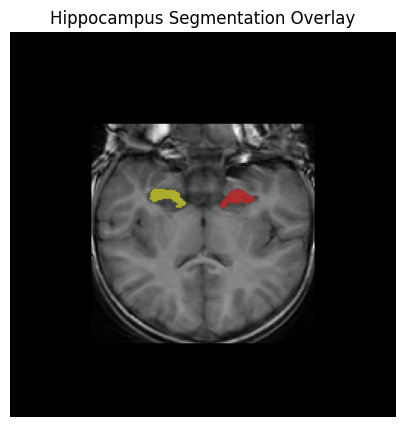

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Set file paths (update to match your dataset location)
image_path = "/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/imagesTr/HC_021_0000.nii.gz"
label_path = "/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/labelsTr/HC_021.nii.gz"

# Load image and label
image = nib.load(image_path).get_fdata()
label = nib.load(label_path).get_fdata()

# Choose a slice to visualize (e.g., middle slice along Z-axis)
slice_idx = image.shape[2] // 2
img_slice = image[:, :, slice_idx]
label_slice = label[:, :, slice_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(img_slice.T, cmap="gray", origin="lower")
plt.imshow(np.ma.masked_where(label_slice == 0, label_slice).T, cmap="autumn", alpha=0.5, origin="lower")
plt.title("Hippocampus Segmentation Overlay")
plt.axis("off")
plt.show()


In [ ]:
print("Unique labels in segmentation:", np.unique(label.astype(int)))


Unique labels in segmentation: [0 1 2]


In [ ]:
import nibabel as nib
import numpy as np

# Load the label image
label_nii = nib.load(label_path)
label_data = label_nii.get_fdata()
label_data = label_data.astype(int)  # Ensure integer comparison

# Count number of voxels for each region
left_voxels = np.sum(label_data == 1)
right_voxels = np.sum(label_data == 2)

# Calculate volumes in mm³
left_volume = left_voxels
right_volume = right_voxels
total_volume = left_volume + right_volume

print(f"Left Hippocampus Volume:  {left_volume:.2f} mm³")
print(f"Right Hippocampus Volume: {right_volume:.2f} mm³")
print(f"Total Hippocampus Volume: {total_volume:.2f} mm³")


Left Hippocampus Volume:  2533.00 mm³
Right Hippocampus Volume: 2699.00 mm³
Total Hippocampus Volume: 5232.00 mm³


In [ ]:
!pip install nibabel matplotlib numpy

In [ ]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git
%cd nnUNet
!pip install -e .

Cloning into 'nnUNet'...
remote: Enumerating objects: 13703, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 13703 (delta 12), reused 0 (delta 0), pack-reused 13684 (from 3)
Receiving objects: 100% (13703/13703), 8.04 MiB | 7.71 MiB/s, done.
Resolving deltas: 100% (10500/10500), done.
/content/nnUNet
Obtaining file:///content/nnUNet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.

In [ ]:
import os

base_path = "/content/drive/MyDrive"
# Set environment variables
os.environ["nnUNet_raw"] = os.path.join(base_path, "nnUNet_raw_data")
os.environ["nnUNet_preprocessed"] = os.path.join(base_path, "nnUNet_preprocessed")
os.environ["nnUNet_results"] = os.path.join(base_path, "nnUNet_results")

# Create folders if they don't exist
os.makedirs(os.environ["nnUNet_raw"], exist_ok=True)
os.makedirs(os.environ["nnUNet_preprocessed"], exist_ok=True)
os.makedirs(os.environ["nnUNet_results"], exist_ok=True)

In [ ]:
from nnunetv2.paths import nnUNet_preprocessed, nnUNet_results, nnUNet_raw

print("Raw:", nnUNet_raw)
print("Preprocessed:", nnUNet_preprocessed)
print("Results:", nnUNet_results)

# # Define base directories
# raw_dataset_dir = "/content/drive/MyDrive/nnUNet_raw_data/Dataset103_Hippocampus"
# imagesTr_src = "/content/drive/MyDrive/Task04_Hippocampus/Task04_Hippocampus/imagesTr"
# labelsTr_src = "/content/drive/MyDrive/Task04_Hippocampus/Task04_Hippocampus/labelsTr"
# imagesTs_src = "/content/drive/MyDrive/Task04_Hippocampus/Task04_Hippocampus/imagesTs"

# # Create nnU-Net expected folders
# import os
# os.makedirs(f"{raw_dataset_dir}/imagesTr", exist_ok=True)
# os.makedirs(f"{raw_dataset_dir}/labelsTr", exist_ok=True)
# os.makedirs(f"{raw_dataset_dir}/imagesTs", exist_ok=True)

Raw: /content/drive/MyDrive/nnUNet_raw_data
Preprocessed: /content/drive/MyDrive/nnUNet_preprocessed
Results: /content/drive/MyDrive/nnUNet_results


In [ ]:
import SimpleITK as sitk
from pathlib import Path

def validate_and_fix_nii_gz(folder):
    for file in Path(folder).glob("*.nii.gz"):
        try:
            # Try to read with SimpleITK
            sitk.ReadImage(str(file))
        except Exception as e:
            print(f"❌ Corrupt file detected: {file.name}. Attempting to re-save with nibabel.")

            # Try fixing it using nibabel
            import nibabel as nib
            try:
                img = nib.load(str(file))
                nib.save(img, str(file))  # overwrite
                print(f"✅ Fixed: {file.name}")
            except Exception as ne:
                print(f"⚠️ Could not fix {file.name}: {ne}")

# Validate training and test images
validate_and_fix_nii_gz("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/imagesTr")
validate_and_fix_nii_gz("/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus/imagesTs")


In [ ]:
!nnUNetv2_convert_MSD_dataset \
  -i "/content/drive/MyDrive/nnUNet_raw_data/Task107_Hippocampus" -overwrite_id 110

Traceback (most recent call last):
  File "/usr/local/bin/nnUNetv2_convert_MSD_dataset", line 8, in <module>
    sys.exit(entry_point())
             ^^^^^^^^^^^^^
  File "/content/nnUNet/nnunetv2/dataset_conversion/convert_MSD_dataset.py", line 128, in entry_point
    convert_msd_dataset(args.i, args.overwrite_id, args.np)
  File "/content/nnUNet/nnunetv2/dataset_conversion/convert_MSD_dataset.py", line 62, in convert_msd_dataset
    assert len(existing_datasets) == 0, f"Target dataset id {target_id} is already taken, please consider changing " \
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: Target dataset id 110 is already taken, please consider changing it using overwrite_target_id. Conflicting dataset: ['Dataset110_Hippocampus'] (check nnUNet_results, nnUNet_preprocessed and nnUNet_raw!)


In [ ]:
from pathlib import Path

imagesTr_dir = Path("/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/imagesTr")

for file in imagesTr_dir.glob("*_0000_0000.nii.gz"):
    new_name = file.name.replace("_0000_0000.nii.gz", "_0000.nii.gz")
    file.rename(file.with_name(new_name))
    print(f"✅ Renamed: {file.name} → {new_name}")


✅ Renamed: BPDwPsy_070_0000_0000.nii.gz → BPDwPsy_070_0000.nii.gz
✅ Renamed: BPDwoPsy_033_0000_0000.nii.gz → BPDwoPsy_033_0000.nii.gz
✅ Renamed: BPDwPsy_083_0000_0000.nii.gz → BPDwPsy_083_0000.nii.gz
✅ Renamed: BPDwPsy_065_0000_0000.nii.gz → BPDwPsy_065_0000.nii.gz
✅ Renamed: BPDwPsy_077_0000_0000.nii.gz → BPDwPsy_077_0000.nii.gz
✅ Renamed: BPDwPsy_080_0000_0000.nii.gz → BPDwPsy_080_0000.nii.gz
✅ Renamed: BPDwoPsy_038_0000_0000.nii.gz → BPDwoPsy_038_0000.nii.gz
✅ Renamed: BPDwPsy_073_0000_0000.nii.gz → BPDwPsy_073_0000.nii.gz
✅ Renamed: BPDwoPsy_034_0000_0000.nii.gz → BPDwoPsy_034_0000.nii.gz
✅ Renamed: BPDwPsy_067_0000_0000.nii.gz → BPDwPsy_067_0000.nii.gz
✅ Renamed: BPDwoPsy_030_0000_0000.nii.gz → BPDwoPsy_030_0000.nii.gz
✅ Renamed: BPDwPsy_078_0000_0000.nii.gz → BPDwPsy_078_0000.nii.gz
✅ Renamed: BPDwoPsy_039_0000_0000.nii.gz → BPDwoPsy_039_0000.nii.gz
✅ Renamed: BPDwPsy_081_0000_0000.nii.gz → BPDwPsy_081_0000.nii.gz
✅ Renamed: BPDwPsy_074_0000_0000.nii.gz → BPDwPsy_074_0000.nii.gz


In [ ]:
from pathlib import Path

imagesTr_dir = Path("/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/imagesTs")

for file in imagesTr_dir.glob("*_0000_0000.nii.gz"):
    new_name = file.name.replace("_0000_0000.nii.gz", "_0000.nii.gz")
    file.rename(file.with_name(new_name))
    print(f"✅ Renamed: {file.name} → {new_name}")


✅ Renamed: BPDwPsy_066_0000_0000.nii.gz → BPDwPsy_066_0000.nii.gz
✅ Renamed: BPDwPsy_069_0000_0000.nii.gz → BPDwPsy_069_0000.nii.gz
✅ Renamed: BPDwPsy_075_0000_0000.nii.gz → BPDwPsy_075_0000.nii.gz
✅ Renamed: BPDwoPsy_031_0000_0000.nii.gz → BPDwoPsy_031_0000.nii.gz
✅ Renamed: BPDwoPsy_035_0000_0000.nii.gz → BPDwoPsy_035_0000.nii.gz
✅ Renamed: BPDwoPsy_036_0000_0000.nii.gz → BPDwoPsy_036_0000.nii.gz
✅ Renamed: BPDwoPsy_042_0000_0000.nii.gz → BPDwoPsy_042_0000.nii.gz
✅ Renamed: BPDwoPsy_048_0000_0000.nii.gz → BPDwoPsy_048_0000.nii.gz
✅ Renamed: BPDwoPsy_050_0000_0000.nii.gz → BPDwoPsy_050_0000.nii.gz
✅ Renamed: BPDwoPsy_060_0000_0000.nii.gz → BPDwoPsy_060_0000.nii.gz
✅ Renamed: HC_012_0000_0000.nii.gz → HC_012_0000.nii.gz
✅ Renamed: HC_022_0000_0000.nii.gz → HC_022_0000.nii.gz
✅ Renamed: HC_013_0000_0000.nii.gz → HC_013_0000.nii.gz
✅ Renamed: HC_024_0000_0000.nii.gz → HC_024_0000.nii.gz
✅ Renamed: HC_029_0000_0000.nii.gz → HC_029_0000.nii.gz
✅ Renamed: SS_085_0000_0000.nii.gz → SS_085_00

In [ ]:
# Plan and preprocess
!nnUNetv2_plan_and_preprocess -d 110 --verify_dataset_integrity

Fingerprint extraction...
Dataset107_Hippocampus
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 82/82 [01:16<00:00,  1.07it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [119. 147. 149.], 3d_lowres: [119, 147, 149]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 127, 'patch_size': (np.

In [ ]:
# Plan and preprocess
!nnUNetv2_plan_and_preprocess -d 110 -c 3d_fullres --verbose

Fingerprint extraction...
Dataset110_Hippocampus
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [119. 147. 149.], 3d_lowres: [119, 147, 149]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 127, 'patch_size': (np.int64(160), np.int64(160)), 'median_image_size_in_voxels': array([147., 149.]), 'spacing': array([0.9375, 0.9375]), 'normalization_schemes': ['ZScoreNormalization'], 'use_mask_for_norm': [True], 'resampling_fn_data': 'resample_data_or_seg_to_shape', 'resampling_fn_seg': 'resample_data_or_seg_to_shape', 'resampling_fn_data_kwargs': {'is_seg': False, 'order'

In [ ]:
!nnUNetv2_train 110 3d_fullres 1


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2025-05-12 21:57:55.696675: Using torch.compile...
2025-05-12 21:57:58.536776: do_dummy_2d_data_aug: False
2025-05-12 21:57:58.551358: Creating new 5-fold cross-validation split...
2025-05-12 21:57:58.561707: Desired fold for training: 1
2025-05-12 21:57:58.566786: This split has 65 training and

In [ ]:
!nnUNetv2_find_best_configuration 110 -c 3d_fullres -f 1


***All results:***
nnUNetTrainer__nnUNetPlans__3d_fullres: 0.7326885179882554

*Best*: nnUNetTrainer__nnUNetPlans__3d_fullres: 0.7326885179882554

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!
Removing all but the largest component for 1 did not improve results! Dice before: 0.7257 after: 0.69385
Results were improved by removing all but the largest component for 2. Dice before: 0.73968 after: 0.75613

***Run inference like this:***

nnUNetv2_predict -d Dataset110_Hippocampus -i INPUT_FOLDER -o OUTPUT_FOLDER -f  1 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans

***Once inference is completed, run postprocessing like this:***

nnUNetv2_apply_postprocessing -i OUTPUT_FOLDER -o OUTPUT_FOLDER_PP -pp_pkl_file /content/drive/MyDrive/nnUNet_results/Dataset110_Hippocampus/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_1/postprocessing.pkl -np 8 -plans_json /content/drive/MyDrive/nnUNet_results/Da

In [ ]:
!nnUNetv2_predict -d 110 -i "/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/imagesTs" -o "/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/Prediction" -f  1 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 21 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 21 cases that I would like to predict

Predicting BPDwPsy_066:
perform_everything_on_device: True
100% 4/4 [00:07<00:00,  1.75s/it]
sending off prediction to background worker for resampling and export
done with BPDwPsy_066

Predicting BPDwPsy_069:
perform_everything_on_device: True
100% 4/4 [00:03<00:00,  1.31it/s]
sending off prediction to background worker for resampling and export
done with BPDwPsy_069

Predicting BPDwPsy_075:
perform_everything_on_device: True
100%

In [ ]:
!nnUNetv2_apply_postprocessing -i "/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/Prediction" -o "/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/PostProcessing" -pp_pkl_file /content/drive/MyDrive/nnUNet_results/Dataset110_Hippocampus/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_1/postprocessing.pkl -np 8 -plans_json /content/drive/MyDrive/nnUNet_results/Dataset110_Hippocampus/nnUNetTrainer__nnUNetPlans__3d_fullres/crossval_results_folds_1/plans.json

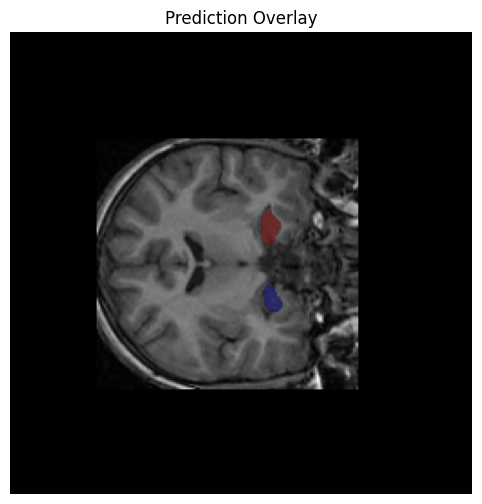

In [ ]:
import nibabel as nib, matplotlib.pyplot as plt, numpy as np

# Load an example image and prediction
img = nib.load("/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/imagesTs/BPDwPsy_066_0000.nii.gz").get_fdata()
pred = nib.load("/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/PostProcessing/BPDwPsy_066.nii.gz").get_fdata()

# Visualize the center axial slice
slice_idx = img.shape[2] // 2
plt.figure(figsize=(8, 6))
plt.imshow(img[:, :, slice_idx], cmap="gray")
plt.imshow(np.ma.masked_where(pred[:, :, slice_idx] == 0, pred[:, :, slice_idx]), cmap="jet", alpha=0.5)
plt.title("Prediction Overlay")
plt.axis("off")
plt.show()


In [ ]:
np.unique(pred)

array([0., 1., 2.])

In [ ]:
# Count number of voxels for each region
left_voxels = np.sum(pred == 1)
right_voxels = np.sum(pred == 2)

# Calculate volumes in mm³
left_volume = left_voxels
right_volume = right_voxels
total_volume = left_volume + right_volume

print(f"Left Hippocampus Volume:  {left_volume:.2f} mm³")
print(f"Right Hippocampus Volume: {right_volume:.2f} mm³")
print(f"Total Hippocampus Volume: {total_volume:.2f} mm³")

Left Hippocampus Volume:  2525.00 mm³
Right Hippocampus Volume: 2223.00 mm³
Total Hippocampus Volume: 4748.00 mm³


In [ ]:
!nnUNetv2_evaluate_folder -h

usage: nnUNetv2_evaluate_folder [-h] -djfile DJFILE -pfile PFILE [-o O]
                                [-np NP] [--chill]
                                gt_folder pred_folder

positional arguments:
  gt_folder       folder with gt segmentations
  pred_folder     folder with predicted segmentations

options:
  -h, --help      show this help message and exit
  -djfile DJFILE  dataset.json file
  -pfile PFILE    plans.json file
  -o O            Output file. Optional. Default: pred_folder/summary.json
  -np NP          number of processes used. Optional. Default: 8
  --chill         dont crash if folder_pred does not have all files that are
                  present in folder_gt


In [ ]:
# Re-import necessary modules after code state reset
import os
import numpy as np
import pandas as pd
import nibabel as nib
# import acetools as tools

# Define paths again
prediction_dir = "/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/PostProcessing"
train = "/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/labelsTr"
voxel_volume_mm3 = 1.0  # Assuming isotropic voxels

# Volume calculation utility
def compute_volumes(mask):
    left = (mask == 1).sum() * voxel_volume_mm3
    right = (mask == 2).sum() * voxel_volume_mm3
    return left, right, left + right

# Loop over all predicted masks
volume_stats = []
train_vol = []
for fname in sorted(os.listdir(prediction_dir)):
    if not fname.endswith(".nii.gz"):
        continue
    path = os.path.join(prediction_dir, fname)
    mask = nib.load(path).get_fdata()
    left_vol, right_vol, total_vol = compute_volumes(mask)
    volume_stats.append((fname, left_vol, right_vol, total_vol))

for fname in sorted(os.listdir(train)):
    if not fname.endswith(".nii.gz"):
        continue
    path = os.path.join(train, fname)
    mask = nib.load(path).get_fdata()
    left_vol, right_vol, total_vol = compute_volumes(mask)
    train_vol.append((fname, left_vol, right_vol, total_vol))


# Create DataFrame
df_volumes = pd.DataFrame(volume_stats, columns=["filename", "anterior_volume", "posterior_volume", "total_volume"])
df_train = pd.DataFrame(train_vol, columns=["filename", "anterior_volume", "posterior_volume", "total_volume"])
# Outlier detection using 5th percentile
total_mean = df_volumes["total_volume"].mean()
total_std = df_volumes["total_volume"].std()
total_5th = np.percentile(df_volumes["total_volume"], 5)

# df_volumes["is_low_volume_outlier"] = df_volumes["total_volume"] < 5000
# df_train["is_low_volume_outlier"] = df_train["total_volume"] < 5000


{
    "mean_total_volume_mm3": round(total_mean, 2),
    "std_total_volume_mm3": round(total_std, 2),
    "5th_percentile_volume_mm3": round(total_5th, 2),
}

{'mean_total_volume_mm3': np.float64(5616.19),
 'std_total_volume_mm3': 798.0,
 '5th_percentile_volume_mm3': np.float64(4708.0)}

In [ ]:
df_volumes

,filename,anterior_volume,posterior_volume,total_volume
0,BPDwPsy_066.nii.gz,2525.0,2223.0,4748.0
1,BPDwPsy_069.nii.gz,2300.0,2661.0,4961.0
2,BPDwPsy_075.nii.gz,2571.0,2785.0,5356.0
3,BPDwoPsy_031.nii.gz,2679.0,2696.0,5375.0
4,BPDwoPsy_035.nii.gz,2749.0,2785.0,5534.0
5,BPDwoPsy_036.nii.gz,2706.0,2895.0,5601.0
6,BPDwoPsy_042.nii.gz,2985.0,3091.0,6076.0
7,BPDwoPsy_048.nii.gz,2797.0,2875.0,5672.0
8,BPDwoPsy_050.nii.gz,5520.0,0.0,5520.0
9,BPDwoPsy_060.nii.gz,2262.0,2446.0,4708.0


In [ ]:
df_train

,filename,anterior_volume,posterior_volume,total_volume
0,BPDwPsy_065.nii.gz,2625.0,2486.0,5111.0
1,BPDwPsy_067.nii.gz,2786.0,2861.0,5647.0
2,BPDwPsy_068.nii.gz,2829.0,2828.0,5657.0
3,BPDwPsy_070.nii.gz,2630.0,2485.0,5115.0
4,BPDwPsy_071.nii.gz,2813.0,2851.0,5664.0
...,...,...,...,...
77,SS_099.nii.gz,3094.0,3276.0,6370.0
78,SS_100.nii.gz,2222.0,2215.0,4437.0
79,SS_101.nii.gz,2171.0,2538.0,4709.0
80,SS_102.nii.gz,2554.0,2611.0,5165.0


In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib

prediction_dir = "/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/PostProcessing"
demographic = "/content/drive/MyDrive/Hippocampus/demographics/SchizBull_2008_Demographics_V1.1.csv"
voxel_volume_mm3 = 1.0  # Assuming isotropic voxel size

# Prepare SubjectID for matching
df_volumes["SubjectID"] = df_volumes["filename"].str.replace(".nii.gz","")
df_train["SubjectID"] = df_train["filename"].str.replace(".nii.gz","")
df_demo = pd.read_csv(demographic)

# Merge volume and demographic data
merged_df = pd.merge(df_volumes, df_demo, left_on="SubjectID", right_on = "Subject", how="left")

In [ ]:
merged_df

,filename,anterior_volume,posterior_volume,total_volume,SubjectID,Subject,Gender,Age,Handedness,Handed_extended,Weight (lbs),Height (in),Head_Circumference (cm),Tanner_Stage
0,BPDwPsy_066.nii.gz,2525.0,2223.0,4748.0,BPDwPsy_066,BPDwPsy_066,female,11.30,LH,mixed.LH,104,59,52.5,4
1,BPDwPsy_069.nii.gz,2300.0,2661.0,4961.0,BPDwPsy_069,BPDwPsy_069,female,16.50,RH,RH,144,69.75,56.2,5
2,BPDwPsy_075.nii.gz,2571.0,2785.0,5356.0,BPDwPsy_075,BPDwPsy_075,male,10.14,RH,RH,98,52.875,54,1
3,BPDwoPsy_031.nii.gz,2679.0,2696.0,5375.0,BPDwoPsy_031,BPDwoPsy_031,female,15.60,RH,mixed.RH,188,61.5,57,5
4,BPDwoPsy_035.nii.gz,2749.0,2785.0,5534.0,BPDwoPsy_035,BPDwoPsy_035,male,8.60,RH,mixed.RH,83,50.5,53.5,1
5,BPDwoPsy_036.nii.gz,2706.0,2895.0,5601.0,BPDwoPsy_036,BPDwoPsy_036,male,8.80,RH,RH,95,53.75,54.5,1
6,BPDwoPsy_042.nii.gz,2985.0,3091.0,6076.0,BPDwoPsy_042,BPDwoPsy_042,male,13.60,RH,RH,95,66,56.2,1
7,BPDwoPsy_048.nii.gz,2797.0,2875.0,5672.0,BPDwoPsy_048,BPDwoPsy_048,female,15.30,RH,mixed.RH,120,61.5,54.2,5
8,BPDwoPsy_050.nii.gz,5520.0,0.0,5520.0,BPDwoPsy_050,BPDwoPsy_050,male,8.90,RH,RH,52.5,52.5,53.5,1
9,BPDwoPsy_060.nii.gz,2262.0,2446.0,4708.0,BPDwoPsy_060,BPDwoPsy_060,female,5.30,RH,RH,53,45,52,1


In [ ]:
def assign_brain_age(volume):
    if volume >= 5300:
        return 25
    elif volume >= 5000:
        return 35
    elif volume >= 4700:
        return 45
    elif volume >= 4400:
        return 55
    elif volume >= 4100:
        return 65
    elif volume >= 3800:
        return 75
    elif volume >= 3500:
        return 85
    else:
        return 90

In [ ]:
merged_df["predicted_brain_age"] = merged_df["total_volume"].apply(assign_brain_age)
merged_df["brain_age_gap"] = merged_df["predicted_brain_age"] - merged_df["Age"]
merged_df["accelerated_aging"] = merged_df["brain_age_gap"] > 5

In [ ]:
merged_df

,filename,anterior_volume,posterior_volume,total_volume,SubjectID,Subject,Gender,Age,Handedness,Handed_extended,Weight (lbs),Height (in),Head_Circumference (cm),Tanner_Stage,predicted_brain_age,brain_age_gap,accelerated_aging
0,BPDwPsy_066.nii.gz,2525.0,2223.0,4748.0,BPDwPsy_066,BPDwPsy_066,female,11.30,LH,mixed.LH,104,59,52.5,4,45,33.70,True
1,BPDwPsy_069.nii.gz,2300.0,2661.0,4961.0,BPDwPsy_069,BPDwPsy_069,female,16.50,RH,RH,144,69.75,56.2,5,45,28.50,True
2,BPDwPsy_075.nii.gz,2571.0,2785.0,5356.0,BPDwPsy_075,BPDwPsy_075,male,10.14,RH,RH,98,52.875,54,1,25,14.86,True
3,BPDwoPsy_031.nii.gz,2679.0,2696.0,5375.0,BPDwoPsy_031,BPDwoPsy_031,female,15.60,RH,mixed.RH,188,61.5,57,5,25,9.40,True
4,BPDwoPsy_035.nii.gz,2749.0,2785.0,5534.0,BPDwoPsy_035,BPDwoPsy_035,male,8.60,RH,mixed.RH,83,50.5,53.5,1,25,16.40,True
5,BPDwoPsy_036.nii.gz,2706.0,2895.0,5601.0,BPDwoPsy_036,BPDwoPsy_036,male,8.80,RH,RH,95,53.75,54.5,1,25,16.20,True
6,BPDwoPsy_042.nii.gz,2985.0,3091.0,6076.0,BPDwoPsy_042,BPDwoPsy_042,male,13.60,RH,RH,95,66,56.2,1,25,11.40,True
7,BPDwoPsy_048.nii.gz,2797.0,2875.0,5672.0,BPDwoPsy_048,BPDwoPsy_048,female,15.30,RH,mixed.RH,120,61.5,54.2,5,25,9.70,True
8,BPDwoPsy_050.nii.gz,5520.0,0.0,5520.0,BPDwoPsy_050,BPDwoPsy_050,male,8.90,RH,RH,52.5,52.5,53.5,1,25,16.10,True
9,BPDwoPsy_060.nii.gz,2262.0,2446.0,4708.0,BPDwoPsy_060,BPDwoPsy_060,female,5.30,RH,RH,53,45,52,1,45,39.70,True


In [ ]:
merged_df["early_atrophy_flag"] = (merged_df["Age"] < 16) & (merged_df["total_volume"] < 5000)
merged_df["accelerated_aging"] = merged_df["brain_age_gap"] > 5
merged_df["high_risk"] = merged_df["early_atrophy_flag"] & merged_df["accelerated_aging"]

In [ ]:
merged_df

,filename,anterior_volume,posterior_volume,total_volume,SubjectID,Subject,Gender,Age,Handedness,Handed_extended,Weight (lbs),Height (in),Head_Circumference (cm),Tanner_Stage,predicted_brain_age,brain_age_gap,accelerated_aging,early_atrophy_flag,high_risk
0,BPDwPsy_066.nii.gz,2525.0,2223.0,4748.0,BPDwPsy_066,BPDwPsy_066,female,11.30,LH,mixed.LH,104,59,52.5,4,45,33.70,True,True,True
1,BPDwPsy_069.nii.gz,2300.0,2661.0,4961.0,BPDwPsy_069,BPDwPsy_069,female,16.50,RH,RH,144,69.75,56.2,5,45,28.50,True,False,False
2,BPDwPsy_075.nii.gz,2571.0,2785.0,5356.0,BPDwPsy_075,BPDwPsy_075,male,10.14,RH,RH,98,52.875,54,1,25,14.86,True,False,False
3,BPDwoPsy_031.nii.gz,2679.0,2696.0,5375.0,BPDwoPsy_031,BPDwoPsy_031,female,15.60,RH,mixed.RH,188,61.5,57,5,25,9.40,True,False,False
4,BPDwoPsy_035.nii.gz,2749.0,2785.0,5534.0,BPDwoPsy_035,BPDwoPsy_035,male,8.60,RH,mixed.RH,83,50.5,53.5,1,25,16.40,True,False,False
5,BPDwoPsy_036.nii.gz,2706.0,2895.0,5601.0,BPDwoPsy_036,BPDwoPsy_036,male,8.80,RH,RH,95,53.75,54.5,1,25,16.20,True,False,False
6,BPDwoPsy_042.nii.gz,2985.0,3091.0,6076.0,BPDwoPsy_042,BPDwoPsy_042,male,13.60,RH,RH,95,66,56.2,1,25,11.40,True,False,False
7,BPDwoPsy_048.nii.gz,2797.0,2875.0,5672.0,BPDwoPsy_048,BPDwoPsy_048,female,15.30,RH,mixed.RH,120,61.5,54.2,5,25,9.70,True,False,False
8,BPDwoPsy_050.nii.gz,5520.0,0.0,5520.0,BPDwoPsy_050,BPDwoPsy_050,male,8.90,RH,RH,52.5,52.5,53.5,1,25,16.10,True,False,False
9,BPDwoPsy_060.nii.gz,2262.0,2446.0,4708.0,BPDwoPsy_060,BPDwoPsy_060,female,5.30,RH,RH,53,45,52,1,45,39.70,True,True,True


In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 82.8 MB/s eta 0:00:00


In [ ]:
low_volume_group = merged_df[merged_df["high_risk"]]["filename"].tolist()
low_volume_group

['BPDwPsy_066.nii.gz', 'BPDwoPsy_060.nii.gz', 'HC_029.nii.gz']

In [ ]:
merged_df['filename'].tolist()

['BPDwPsy_066.nii.gz',
 'BPDwPsy_069.nii.gz',
 'BPDwPsy_075.nii.gz',
 'BPDwoPsy_031.nii.gz',
 'BPDwoPsy_035.nii.gz',
 'BPDwoPsy_036.nii.gz',
 'BPDwoPsy_042.nii.gz',
 'BPDwoPsy_048.nii.gz',
 'BPDwoPsy_050.nii.gz',
 'BPDwoPsy_060.nii.gz',
 'HC_012.nii.gz',
 'HC_013.nii.gz',
 'HC_022.nii.gz',
 'HC_024.nii.gz',
 'HC_029.nii.gz',
 'SS_085.nii.gz',
 'SS_086.nii.gz',
 'SS_092.nii.gz',
 'SS_093.nii.gz',
 'SS_096.nii.gz',
 'SS_098.nii.gz']

In [ ]:
from pathlib import Path

# Define your image directory
image_dir = Path("/content/drive/MyDrive/nnUNet_raw_data/Dataset110_Hippocampus/PostProcessing")

# Build full paths for second-level input
second_level_input = [str(image_dir / fname) for fname in merged_df['filename'].tolist()]

# Also update the low_volume_group to use full paths
low_volume_group_paths = [str(image_dir / fname) for fname in low_volume_group]

# Design matrix for second-level model
design_matrix = pd.DataFrame(
    [1 if fname in low_volume_group_paths else 0 for fname in second_level_input],
    columns=['group']
)
all_imgs = [load_img(image_dir / fname) for fname in merged_df['filename'].tolist()]
ref_img = all_imgs[0]


In [ ]:
from nilearn.image import resample_to_img

# Resample all images to match reference
resampled_imgs = [resample_to_img(img, ref_img, interpolation='continuous') for img in all_imgs]

<ipython-input-23-a1de5df8e4ca>:4: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_imgs = [resample_to_img(img, ref_img, interpolation='continuous') for img in all_imgs]
/usr/local/lib/python3.11/dist-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


/usr/local/lib/python3.11/dist-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)
/usr/local/lib/python3.11/dist-packages/nilearn/plotting/displays/_slicers.py:1497: UserWarning: A non-diagonal affine is found in the given image. Reordering the image to get diagonal affine for finding cuts in the slices.
  cut_coords = find_cut_slices(


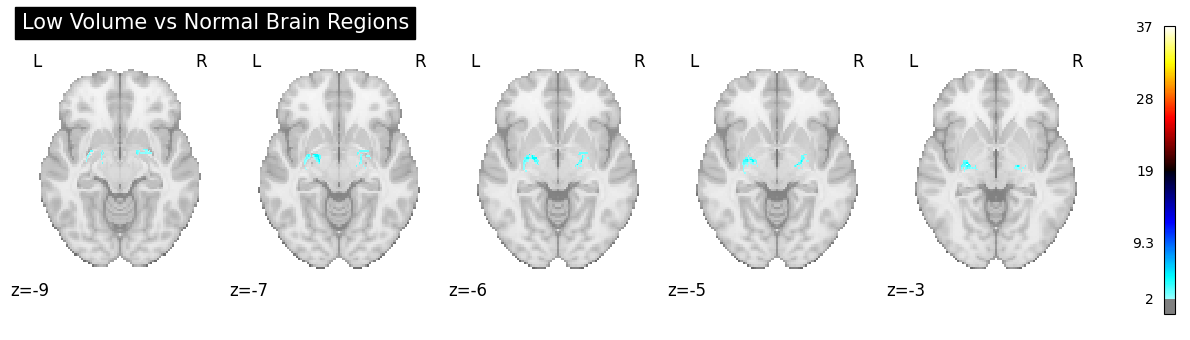

In [ ]:
from nilearn.image import math_img, load_img
from nilearn.plotting import plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
import pandas as pd

# Fit model
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(resampled_imgs, design_matrix=design_matrix)

# Contrast and plot
z_map = second_level_model.compute_contrast("group", output_type="z_score")
from nilearn.plotting import plot_stat_map
plot_stat_map(z_map, threshold=2.0, display_mode='z', cut_coords=5,
              title='Low Volume vs Normal Brain Regions')


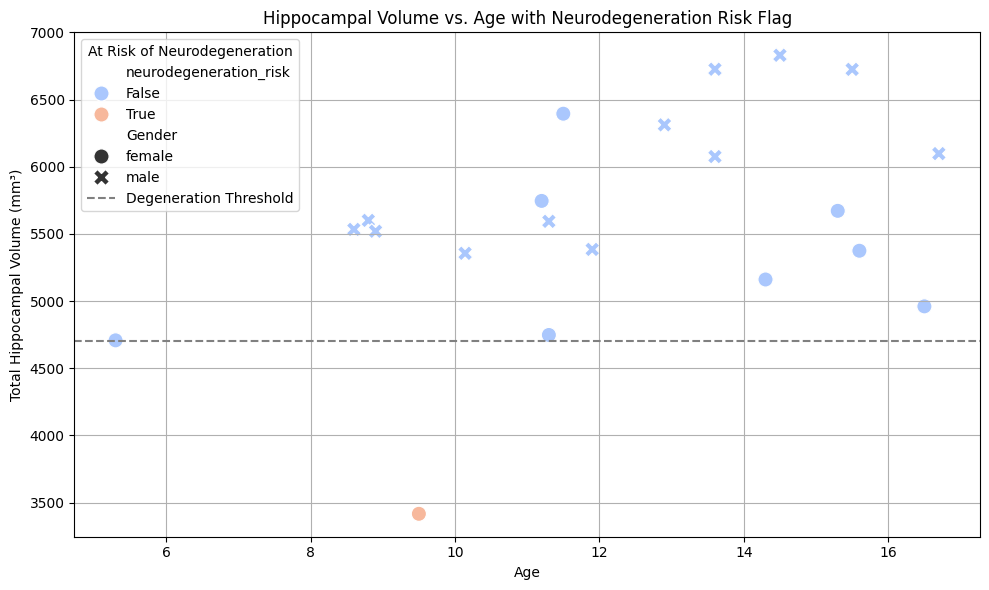

In [ ]:
import numpy as np
import seaborn as sns

# Example threshold for "neurodegeneration risk" based on total volume
neurodegeneration_threshold = 4700  # This can be adjusted based on studies

# Flag subjects with potentially low volume for their age
merged_df["neurodegeneration_risk"] = merged_df["total_volume"] < neurodegeneration_threshold

# Scatterplot: age vs total volume colored by risk
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x="Age", y="total_volume", hue="neurodegeneration_risk", style="Gender", palette="coolwarm", s=120)
plt.axhline(neurodegeneration_threshold, color='gray', linestyle='--', label='Degeneration Threshold')
plt.title("Hippocampal Volume vs. Age with Neurodegeneration Risk Flag")
plt.xlabel("Age")
plt.ylabel("Total Hippocampal Volume (mm³)")
plt.legend(title="At Risk of Neurodegeneration")
plt.grid(True)
plt.tight_layout()
plt.show()